In [28]:
import json
import pandas as pd
import numpy as np  
import os
import random

from metric import r_precision, dcg_at_k, ndcg_at_k
from utils import generate_playlists, generate_testcases

from numpy import linalg as LA

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import collections

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [29]:
path_to_data = '/content/drive/MyDrive/DO_AN_KHDL/DATA'
path_audio_feats = os.path.join(path_to_data, 'audio_features.tsv')
path_playlists = os.path.join(path_to_data, 'playlists.tsv')
path_tracks = os.path.join(path_to_data, 'tracks.tsv')

In [30]:
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_playlists = pd_playlists.fillna('None')

In [31]:
pd_tracks = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_tracks, pd_playlists, left_on = 'playlist_id', right_on = 'playlist_id')

pd_tracks = pd_tracks.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [32]:
pd_full.shape

(86400, 27)

In [33]:
#Thông tin rỗng là discription, ta có thể chỉ điền vào "None"
pd_full = pd_full.fillna('None')

In [34]:
#Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()

In [35]:
pd_full['available_markets'] = pd_full['available_markets'].apply(lambda x : x[1:-1].split(', '))
pd_full['count_available_markets'] = pd_full['available_markets'].apply(lambda x : len(x))

In [36]:
pd_full.shape

(86350, 28)

In [37]:
pd_full.head()

,track_id,track_name,playlist_id,playlist_name_x,artist_ids,artist_names,album_id,album_name,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,time_signature,available_markets,popularity,description,num_tracks,num_followers,count_available_markets
0,463CkQjx2Zk1yXoBuierM9,Levitating (feat. DaBaby),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['6M2wZ9GZgrQXHCFfjv46we', '4r63FhuTkUYltbVAg5...","['Dua Lipa', 'DaBaby']",04m06KhJUuwe1Q487puIud,Levitating (feat. DaBaby),203064,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.00000,0.0674,0.915,102.977,https://api.spotify.com/v1/audio-analysis/463C...,4,"['AD', 'AE', 'AL', 'AR', 'AU', 'BA', 'BE', 'BG...",90,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,88
1,7igeByaBM0MgGsgXtNxDJ7,positions,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],3jqEvfiu2ENgmgzZq27zbi,positions,172324,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.00000,0.0940,0.675,144.005,https://api.spotify.com/v1/audio-analysis/7ige...,4,[],76,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,1
2,0lx2cLdOt3piJbcaXIV74f,willow,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['06HL4z0CvFAxyc27GXpf02'],['Taylor Swift'],2Xoteh7uEpea4TohMxjtaq,evermore,214706,0.392,0.574,7,-9.195,1,0.1700,0.83300,0.00179,0.1450,0.529,81.112,https://api.spotify.com/v1/audio-analysis/0lx2...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",91,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,91
3,2Z8yfpFX0ZMavHkcIeHiO1,Monster (Shawn Mendes & Justin Bieber),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['7n2wHs1TKAczGzO7Dd2rGr', '1uNFoZAHBGtllmzznp...","['Shawn Mendes', 'Justin Bieber']",3yVVL2EYLp8g7gT08VvYKy,Monster,178994,0.652,0.383,2,-7.076,0,0.0516,0.06760,0.00000,0.0828,0.549,145.765,https://api.spotify.com/v1/audio-analysis/2Z8y...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",93,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,91
4,6zFMeegAMYQo0mt8rXtrli,HOLIDAY,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['7jVv8c5Fj3E9VhNjxT4snq'],['Lil Nas X'],4EvukZrmNBiqJbs3LwOSHu,HOLIDAY,154997,0.810,0.511,5,-6.924,0,0.1640,0.12000,0.00000,0.0832,0.837,151.947,https://api.spotify.com/v1/audio-analysis/6zFM...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",93,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,92


## k-nearest-neighbors

**Ý tưởng model**: Với mỗi input là playlist hiện có **N** bài hát, ta sẽ sử dụng tất cả các đặc trưng số thực của mỗi bài hát (danceability, energy, key, loudness, v.v.) để đại diện cho mỗi bài. *Thuật toán*: 

- Tính trung bình các giá trị đặc trưng số thực trên của tất cả **N** bài hát, ta coi bài hát mang giá trị trung bình này là **mean song**. 

- Tìm k người hàng xóm gần nhất (k-nearest-neighbors) (khoảng cách norm-t gần nhất tính trên tất cả các features, t là số features sử dụng) từ database của **mean song**.

- Thực hiện đề xuất các bài hát từ k người hàng xóm này theo độ ưu tiên: **'tần suất xuất hiện', 'độ phổ biến'** (đặc trưng **popularity**).

### create test-cases

In [38]:
fraction = 3
nums_playlists_test = 100

track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
track_id_test = generate_testcases(track_id_all, fraction = fraction)

In [39]:
all_playlistID_for_tests = list(track_id_test.keys())

In [40]:
pd_full_tests = pd_full.copy()
pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
pd_full_tests = pd_full_tests.reset_index(drop = True)
pd_full_tests_copy = pd_full_tests.copy()

In [41]:
omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'description', 'num_followers', 'available_markets', 'num_tracks']
pd_full_tests_copy = pd_full_tests_copy.drop(omit_feats, 1)

### modeling

In [42]:
def k_nearest_neighbors_model(tracks, df, n_pred, feats):
    mean_songs = df.copy().iloc[0] #dict

    df_rest = df[~(df['track_id'].isin(tracks))]
    
    for feat in feats:
      mean_songs[feat] = np.mean(df[df['track_id'].isin(tracks)][feat].values)
    
    np_values = np.array(df[feats].values)
    np_mean_values = np.array(mean_songs[feats].values)

    dist = (np_mean_values - np_values) ** len(feats)
    dist = np.sum(dist, axis=1)
    dist = dist ** (1 / (len(feats)))

    index_min = dist.argsort()[:(n_pred * max(3, len(feats)))]

    df_min = df.iloc[index_min]
    df_min = df_min.sort_values(by = 'popularity', ascending=False)

    recs_id = df_min['track_id']

    preds = collections.Counter(recs_id).most_common(n_pred)
    pred_titles = [p[0] for p in preds]

    tracks_name = []
    for id_track in pred_titles:
      tracks_name.extend(list(np.unique(df[df['track_id'] == id_track]['track_name'].values)))

    return pred_titles, tracks_name

### testing

**Bây giờ ta sẽ thử test phương pháp này trên playlist đầu tiên của tập test**

In [43]:
features = pd_full_tests_copy.columns

In [44]:
playlists_to_test = all_playlistID_for_tests[0]

In [45]:
all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[playlists_to_test])]['track_name'].values)
given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[playlists_to_test])]['track_name'].values)

In [46]:
track_id_result, track_name_result = k_nearest_neighbors_model(track_id_test[playlists_to_test], pd_full_tests, len(track_id_all[playlists_to_test])-len(track_id_test[playlists_to_test]), features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


In [47]:
print('Songs given: ', given_songs_name, '\n')
print('Songs recommended: ', track_name_result, '\n')

Songs given:  ['Better', '+HWA+', 'NUNU NANA', "I'M OKAY", 'Better', 'NUNU NANA', 'Better', '+HWA+', 'NUNU NANA', 'One Day by Chance', 'stupid thought (Feat. BRWN, Novah the Ade)', 'U & ME - Between you and me (feat. Woozys, Seohyun)', 'Island', 'Happy Now!', 'ISLAND', 'Better Me', 'Make Me Better', 'PLAY', "I'M OKAY", 'pporappippam 보라빛 밤', 'Happy', 'Noise Cancelling', 'Spit it out', 'My Friend', 'INCOMPLETE', 'zZ(Tired) zZ(피곤해) (With Yebit)', 'KnoCK (Feat. Yerin Baek)', 'One Day by Chance', 'ISLAND', 'PLAY'] 

Songs recommended:  ['Sigur 3 (Untitled)', 'Then the Quiet Explosion', 'I Can Almost See You', 'HOLIDAY', "Don't", 'River', 'Sweet Melody', 'Window', 'Softly', 'Visions of Gideon', 'Inside Friend (feat. John Mayer)', 'A Case of You', 'In the Air', 'Both Sides Now', 'California', 'just a boy', 'Gnossienne No. 1', 'Broke', 'Chocolate. (ft. Ari Lennox)', 'Fresh Roses', 'Back Pocket', 'Wading In Waist-High Water', 'Sense of Home', "Sure Don't Miss You", 'Sweeter (feat. Terrace Marti

**Bây giờ ta sẽ sử dụng tất cả 100 playlists trong bộ test để đánh giá**

In [48]:
def test_multi_feats(pd_playlists, pd_full, features, fraction = 5, nums_playlists_test = 100):
  r_score = []

  track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
  track_id_test = generate_testcases(track_id_all, fraction = fraction)

  all_playlistID_for_tests = list(track_id_test.keys())

  pd_full_tests = pd_full.copy()
  pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
  pd_full_tests = pd_full_tests.reset_index(drop = True)

  for each_playlist in all_playlistID_for_tests:
    track_id_result, track_name_result = k_nearest_neighbors_model(track_id_test[each_playlist], pd_full_tests, len(track_id_all[each_playlist])-len(track_id_test[each_playlist]), features)

    all_name_songs = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_all[each_playlist])]['track_name'].values)
    given_songs_name = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_test[each_playlist])]['track_name'].values) 
    test_songs_name = [x for x in all_name_songs if x not in given_songs_name]

    r_score.append(r_precision(track_name_result, test_songs_name))

  return r_score

In [49]:
r_score = test_multi_feats(pd_playlists, pd_full, features, fraction = 5, nums_playlists_test = 100)

print("Average R precision: " + str(np.mean(r_score)))
print("Max R precision: " + str(np.max(r_score)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Average R precision: 0.009080534016683604
Max R precision: 0.18333333333333332


**Test model trên những fraction khác nhau**:

Fraction là tỷ lệ bài hát hiện có trong mỗi playlist, ta dựa vào chúng để đề xuất các bài hát còn lại, ví dụ playlist có 100 bài hát, ta dùng 1/5 số đó (20 bài hát) để dựa vào đó đề xuất 80 bài hát còn lại.

Fraction có giá trị càng bé hoặc càng lớn thì tỷ lệ đề xuất trúng càng thấp.

Ở đây ta test model với các fraction lần lượt là 2 - 10, tức là trong một playlist có 100 bài hát thì ta sẽ dùng 50, 100/3, 25, ..., 10 bài hát đầu tiên để đề xuất số bài hát còn lại.

In [50]:
fraction_to_test = list(np.arange(2, 11))

result_mean = {}
result_max = {}

for fraction in fraction_to_test:
  r_score = test_multi_feats(pd_playlists, pd_full, features, fraction = fraction, nums_playlists_test = 100)
  result_mean[fraction] = np.mean(r_score)
  result_max[fraction] = np.max(r_score)
  print('-'*30)
  print(f'fraction {fraction}:')
  print("Average R precision: " + str(np.mean(r_score)))
  print("Max R precision: " + str(np.max(r_score))) 
  print('-'*30)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in power
  


------------------------------
fraction 2:
Average R precision: 0.004938097005377919
Max R precision: 0.25
------------------------------
------------------------------
fraction 3:
Average R precision: 0.005866021053772506
Max R precision: 0.08823529411764706
------------------------------
------------------------------
fraction 4:
Average R precision: 0.01063585717540437
Max R precision: 0.33783783783783783
------------------------------


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


------------------------------
fraction 5:
Average R precision: 0.010983709999147747
Max R precision: 0.20253164556962025
------------------------------
------------------------------
fraction 6:
Average R precision: 0.0055710888008866045
Max R precision: 0.07407407407407407
------------------------------
------------------------------
fraction 7:
Average R precision: 0.011787654976961576
Max R precision: 0.234375
------------------------------
------------------------------
fraction 8:
Average R precision: 0.00949223147392199
Max R precision: 0.3220338983050847
------------------------------
------------------------------
fraction 9:
Average R precision: 0.011974480129593111
Max R precision: 0.35555555555555557
------------------------------
------------------------------
fraction 10:
Average R precision: 0.011245467829569325
Max R precision: 0.4888888888888889
------------------------------


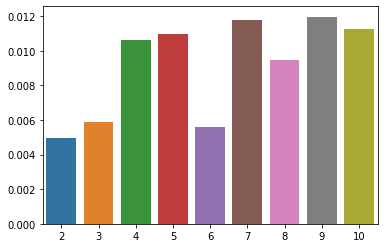

In [51]:
sns.barplot(x=list(result_mean.keys()), y=list(result_mean.values()))

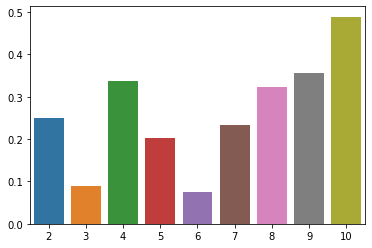

In [52]:
sns.barplot(x=list(result_max.keys()), y=list(result_max.values()))

**Nhận xét**: 

Kết quả **Average R precision** giảm dần khi giá trị fraction tăng từ 2 - 10, tức là số lượng bài hát input dùng để đề xuất càng nhiều thì model hoạt động càng tốt. Tuy nhiên nhìn chung **Average R precision** vẫn còn khá thấp (< 1 %), tức là tỷ lệ đề xuất trung bình 

Kết quả **Max R precision** biến động hơn so với giá trị **Average R precision**, có một số playlist đề xuất được đúng khá nhiều bài hát (**Max R precision** khi **fraction = 2** lên tới gần 0.06).